In [176]:
import os
import random

import pandas as pd
import numpy as np
import scipy as sp

from PIL import Image

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, fbeta_score

import tqdm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from joblib import Parallel, delayed

import imgaug

import copy
import pickle

In [19]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [20]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [21]:
def create_oh_labels(df, nclasses):
    res = np.zeros((df.shape[0], nclasses))
    
    for idx, lbls in enumerate(df.attribute_ids.values):
        res[idx, lbls] = 1
    
    return res

In [22]:
from torch.optim import Optimizer

class CyclicLR(object):
    """Sets the learning rate of each parameter group according to
    cyclical learning rate policy (CLR). The policy cycles the learning
    rate between two boundaries with a constant frequency, as detailed in
    the paper `Cyclical Learning Rates for Training Neural Networks`_.
    The distance between the two boundaries can be scaled on a per-iteration
    or per-cycle basis.
    Cyclical learning rate policy changes the learning rate after every batch.
    `batch_step` should be called after a batch has been used for training.
    To resume training, save `last_batch_iteration` and use it to instantiate `CycleLR`.
    This class has three built-in policies, as put forth in the paper:
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    This implementation was adapted from the github repo: `bckenstler/CLR`_
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        base_lr (float or list): Initial learning rate which is the
            lower boundary in the cycle for eachparam groups.
            Default: 0.001
        max_lr (float or list): Upper boundaries in the cycle for
            each parameter group. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function. Default: 0.006
        step_size (int): Number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch. Default: 2000
        mode (str): One of {triangular, triangular2, exp_range}.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
            Default: 'triangular'
        gamma (float): Constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
            Default: 1.0
        scale_fn (function): Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
            Default: None
        scale_mode (str): {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle).
            Default: 'cycle'
        last_batch_iteration (int): The index of the last batch. Default: -1
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.CyclicLR(optimizer)
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         scheduler.batch_step()
        >>>         train_batch(...)
    .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    .. _bckenstler/CLR: https://github.com/bckenstler/CLR
    """

    def __init__(self, optimizer, base_lr=1e-3, max_lr=6e-3,
                 step_size=2000, mode='triangular', gamma=1.,
                 scale_fn=None, scale_mode='cycle', last_batch_iteration=-1):

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        if isinstance(base_lr, list) or isinstance(base_lr, tuple):
            if len(base_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} base_lr, got {}".format(
                    len(optimizer.param_groups), len(base_lr)))
            self.base_lrs = list(base_lr)
        else:
            self.base_lrs = [base_lr] * len(optimizer.param_groups)

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)

        self.step_size = step_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.batch_step(last_batch_iteration + 1)
        self.last_batch_iteration = last_batch_iteration

    def batch_step(self, batch_iteration=None):
        if batch_iteration is None:
            batch_iteration = self.last_batch_iteration + 1
        self.last_batch_iteration = batch_iteration
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        step_size = float(self.step_size)
        cycle = np.floor(1 + self.last_batch_iteration / (2 * step_size))
        x = np.abs(self.last_batch_iteration / step_size - 2 * cycle + 1)

        lrs = []
        param_lrs = zip(self.optimizer.param_groups, self.base_lrs, self.max_lrs)
        for param_group, base_lr, max_lr in param_lrs:
            base_height = (max_lr - base_lr) * np.maximum(0, (1 - x))
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_batch_iteration)
            lrs.append(lr)
        return lrs

In [90]:
class BaselineDataset(Dataset):
    def __init__(self, df, img_path, nclasses, trans=None, is_test=False):
        self.is_test = is_test
        
        self.img_path = img_path
        self.trans = trans
        self.img_names = df.image.values
        self.nclasses = nclasses
        
        if not(self.is_test):
            self.ids = df.attribute_ids.values

    def _read_single(self, img_name):
        img_path = os.path.join(self.img_path, img_name)
        return Image.open(img_path)

    def _oh_labels(self, lbls):
        res = np.zeros(self.nclasses, dtype=np.float32)
        res[lbls] = 1
        
        return res
    
    def __getitem__(self, index):
        img = self._read_single(self.img_names[index])
        
        if self.trans:
            img = self.trans(img)
        
        if self.is_test:
            labels = None
        else:        
            labels = self._oh_labels(self.ids[index])
        
        return img, labels

    def __len__(self):
        return len(self.img_names)

In [24]:
def train_epoch(train_loader, model, loss_fn, optimizer, scheduler=None, tqdm_module=tqdm.tqdm, disable_tqdm=False):
    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in tqdm_module(enumerate(train_loader), total=len(train_loader), leave=False, disable=disable_tqdm):
        if not (type(data) in [list, tuple]):
            data = (data,)

        data = (d.cuda() for d in data)
        target = target.type(torch.float).cuda()

        optimizer.zero_grad()
        outputs = model(*data)

        loss = loss_fn(outputs, target)

        losses.append(loss.item())
        total_loss += loss.item()

        loss.backward()

        optimizer.step()

        if scheduler:
            scheduler.batch_step()

    total_loss /= (batch_idx + 1)
    return total_loss


def test_epoch(val_loader, model, loss_fn):
    with torch.no_grad():
        model.eval()

        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            if not (type(data) in [list, tuple]):
                data = (data,)

            data = (d.cuda() for d in data)
            target = target.type(torch.float).cuda()

            outputs = model(*data)
            loss = loss_fn(outputs, target)

            val_loss += loss.item()

    val_loss /= (batch_idx + 1)
    return val_loss

def predict(model, loader):
    res = list()

    with torch.no_grad():
        model.eval()

        for (data, target) in loader:
            if not (type(data) in [list, tuple]):
                data = (data,)

            data = (d.cuda() for d in data)
            outputs = model(*data).cpu().numpy()
            res.append(outputs)

    return np.vstack(np.array(res))

In [25]:
def resnet34_body():
    mdl = models.resnet34(pretrained=True)
    input_size = list(mdl.children())[~0].in_features
    
    return nn.Sequential(*list(mdl.children())[:-1]), input_size

def resnet101_body():
    mdl = models.resnet101(pretrained=True)
    input_size = list(mdl.children())[~0].in_features
    
    return nn.Sequential(*list(mdl.children())[:-1]), input_size

def resnet50_body():
    mdl = models.resnet50(pretrained=True)
    input_size = list(mdl.children())[~0].in_features
    
    return nn.Sequential(*list(mdl.children())[:-1]), input_size

def densenet121_body():
    mdl = models.densenet121(pretrained=True)
    input_size = mdl.classifier.in_features
    
    return nn.Sequential(*list(mdl.features.children())), input_size

def densenet201_body():
    mdl = models.densenet201(pretrained=True)
    input_size = mdl.classifier.in_features
    
    return nn.Sequential(*list(mdl.features.children())), input_size


class NeuralNetBaseline(nn.Module):
    def __init__(self, body_func, nclasses):
        super(NeuralNetBaseline, self).__init__()

        self.body, input_size = body_func()
        self.freeze_body(True)
        
        self.head = nn.Linear(input_size, nclasses)
    
    def freeze_body(self, freeze=True):
        for param in self.body.parameters():
            param.requires_grad = not(freeze)
        
    def forward(self, x):
        features = self.body(x)
        features = features.view(features.size(0), -1)
        out = torch.sigmoid(self.head(features))

        return out
    
class NeuralNetComplexHead(nn.Module):
    def __init__(self, body_func, nclasses, use_densenet=False, sigmoid=True):
        super(NeuralNetComplexHead, self).__init__()
        self.use_densenet=use_densenet

        self.body, input_size = body_func()
        self.freeze_body(True)
        
        self.head = nn.Linear(input_size, nclasses)
        self.drop = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(input_size)
        self.sigmoid = sigmoid
    
    def freeze_body(self, freeze=True):
        for param in self.body.parameters():
            param.requires_grad = not(freeze)
        
    def forward(self, x):
        features = self.body(x)
        if self.use_densenet:
            out = F.relu(features, inplace=True)
            out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        else:
            out = features.view(features.size(0), -1)
    
        out = self.drop(self.bn(out))
        out = self.head(out)
        if self.sigmoid:
            out = torch.sigmoid(out)

        return out

In [26]:
import torch.nn.functional as F
def custom_f1_loss(predict, target):
    loss = 0
    lack_cls = target.sum(dim=0) == 0
    if lack_cls.any():
        loss += F.binary_cross_entropy(
            predict[:, lack_cls], target[:, lack_cls])
    predict = torch.clamp(predict * (1-target), min=0.01) + predict * target
    tp = predict * target
    tp = tp.sum(dim=0)
    precision = tp / (predict.sum(dim=0) + 1e-8)
    recall = tp / (target.sum(dim=0) + 1e-8)
    f1 = 2 * (precision * recall / (precision + recall + 1e-8))
    return 1 - f1.mean() + loss

In [51]:
class RandomGaussianNoise(object):
    def __init__(self, p=0.5, sigma=1):
        self.sigma = sigma
        self.p = 0.5
        
    def __call__(self, img):
        prob = np.random.uniform()
        
        if(prob > self.p):
            return img
        
        row, col = img.size
        noise = np.random.normal(0.0, self.sigma, (col,row,3))

        img_trans = np.clip(img + noise, 0, 255)
        return Image.fromarray(img_trans.astype('uint8'))
    
    def __repr__(self):
        params = ','.join(['{}={}'.format(key, val) for key, val in self.__dict__.items()])
        return '{}({})'.format(self.__class__.__name__, params)
    
class RandomGaussianBlur(object):
    def __init__(self, p=0.5, sigma=1):
        self.p = p
        self.sigma = sigma
        self.augmenter = imgaug.augmenters.GaussianBlur(sigma)
    
    def __call__(self, img):
        prob = np.random.uniform()
        
        if(prob > self.p):
            return img
        
        img_trans = self.augmenter.augment_image(np.array(img))
        return Image.fromarray(img_trans.astype('uint8'))
    
    def __repr__(self):
        params = ','.join(['{}={}'.format(key, val) for key, val in self.__dict__.items()])
        return '{}({})'.format(self.__class__.__name__, params)
    
class RandomRotation(object):
    def __init__(self, p=0.5, degrees=30):
        self.p = p
        self.degrees = degrees
        self.augmenter = transforms.RandomRotation(degrees)
        
    def __call__(self, img):
        prob = np.random.uniform()
        
        if prob > self.p:
            return img
        
        return self.augmenter(img)
    
    def __repr__(self):
        params = ','.join(['{}={}'.format(key, val) for key, val in self.__dict__.items()])
        return '{}({})'.format(self.__class__.__name__, params)
    
class RandomAffine(object):
    def __init__(self, p=0.5, degrees=30):
        self.p = p
        self.degrees = degrees
        self.augmenter = transforms.RandomAffine(degrees=degrees)
    
    def __call__(self, img):
        prob = np.random.uniform()
        
        if prob > self.p:
            return img
        
        return self.augmenter(img) 
    
    def __repr__(self):
        params = ','.join(['{}={}'.format(key, val) for key, val in self.__dict__.items()])
        return '{}({})'.format(self.__class__.__name__, params)

class RandomHueSaturation(object):
    def __init__(self, p=0.5, min=-10, max=10):
        self.p = p
        self.min = min
        self.max = max
    
    def __call__(self, img):
        prob = np.random.uniform()
        
        if prob > self.p:
            return img
        
        augmenter = imgaug.augmenters.AddToHueAndSaturation(int(np.random.uniform(self.min, self.max)))
        
        img_trans = augmenter.augment_image(np.array(img))
        return Image.fromarray(img_trans.astype('uint8'))
    
    def __repr__(self):
        params = ','.join(['{}={}'.format(key, val) for key, val in self.__dict__.items()])
        return '{}({})'.format(self.__class__.__name__, params)
    
class RandomCoarseDropout(object):
    def __init__(self, p=0.5, drop_prob=0.1, size_percent=0.2):
        self.p = p
        self.drop_prob = drop_prob
        self.augmenter = imgaug.augmenters.CoarseDropout(drop_prob, size_percent=size_percent)
    
    def __call__(self, img):
        prob = np.random.uniform()
        
        if(prob > self.p):
            return img
        
        img_trans = self.augmenter.augment_image(np.array(img))
        return Image.fromarray(img_trans.astype('uint8'))
    
    def __repr__(self):
        params = ','.join(['{}={}'.format(key, val) for key, val in self.__dict__.items()])
        return '{}({})'.format(self.__class__.__name__, params)

    
class RandomBrightness(object):
    def __init__(self, p=0.5, min=-50, max=50):
        self.p = p
        self.min = min
        self.max = max
    
    def __call__(self, img):
        prob = np.random.uniform()
        
        if(prob > self.p):
            return img
        
        augmenter = imgaug.augmenters.Add(int(np.random.uniform(self.min, self.max)))
        
        img_trans = augmenter.augment_image(np.array(img))
        return Image.fromarray(img_trans.astype('uint8'))
    
    def __repr__(self):
        params = ','.join(['{}={}'.format(key, val) for key, val in self.__dict__.items()])
        return '{}({})'.format(self.__class__.__name__, params)
    
class RandomGamma(object):
    def __init__(self, p=0.5, min=0.5, max=1.5):
        self.p = p
        self.min = min
        self.max = max
    
    def __call__(self, img):
        prob = np.random.uniform()
        
        if(prob > self.p):
            return img
        
        augmenter = imgaug.augmenters.GammaContrast(np.random.uniform(self.min, self.max))
        
        img_trans = augmenter.augment_image(np.array(img))
        return Image.fromarray(img_trans.astype('uint8'))
    
    def __repr__(self):
        params = ','.join(['{}={}'.format(key, val) for key, val in self.__dict__.items()])
        return '{}({})'.format(self.__class__.__name__, params)

In [28]:
def get_f2_score(model, loader, test_df, use_sigmoid=False):
    logits = predict(model, loader)
    if use_sigmoid:
        logits = sigmoid(logits)
    lbls_oh = create_oh_labels(test_df, len(labels_df))

    return fbeta_score(lbls_oh, logits >= 0.2, 2, average='micro')

In [29]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [30]:
labels_df = pd.read_csv('../input/labels.csv')
df = pd.read_csv('../input/train.csv')
df['attribute_ids'] = df['attribute_ids'].apply(lambda x: [int(idx) for idx in x.split()])
df['image'] = df['id'].apply(lambda idx: idx + '.png')

In [31]:
df_labels_oh = create_oh_labels(df, len(labels_df)).astype(int)
labels_freq = df_labels_oh.sum(axis=0)

In [32]:
mskf = MultilabelStratifiedKFold(n_splits=5, random_state=42)
for train_idx, test_idx in mskf.split(df.image.values, df_labels_oh):
    break

In [33]:
train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]

In [65]:
aug_search_space = [
                    {'augmentation': transforms.RandomHorizontalFlip, 'kwargs': {'p': [0, 0.25, 0.5, 0.75]}},
                    {'augmentation': transforms.RandomVerticalFlip, 'kwargs': {'p': [0, 0.25, 0.5, 0.75]}},
                    {'augmentation': RandomRotation, 'kwargs': {'p': [0, 0.25, 0.5, 0.75], 'degrees': [10, 20, 30]}},
                    {'augmentation': RandomAffine, 'kwargs': {'p': [0, 0.25, 0.5, 0.75], 'degrees': [10, 20, 30]}},
                    {'augmentation': RandomCoarseDropout, 'kwargs': {'p': [0, 0.25, 0.5, 0.75], 'drop_prob': [0.025, 0.05, 0.1, 0.15], 'size_percent':[0.1,0.15,0.2,0.25]}},
                    {'augmentation': RandomGaussianBlur, 'kwargs': {'p': [0, 0.25, 0.5, 0.75], 'sigma': [1,2,3,4]}},
                    {'augmentation': RandomGaussianNoise, 'kwargs': {'p': [0, 0.25, 0.5, 0.75], 'sigma': [5,10,15,20]}},
                    {'augmentation': RandomGamma, 'kwargs': {'p': [0, 0.25, 0.5, 0.75], 'min': [0.5, 0.65, 0.8], 'max':[0.5, 0.65, 0.8]}},
                    {'augmentation': RandomBrightness, 'kwargs': {'p': [0, 0.25, 0.5, 0.75], 'min': [-50, -40, -30], 'max': [30, 40, 50]}},
                    {'augmentation': RandomHueSaturation, 'kwargs': {'p': [0, 0.25, 0.5, 0.75], 'min': [-20, -10, -5], 'max': [5, 10, 20]}},
]

In [165]:
base_transforms = [
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                  ]

def sample_augmentation(space, prefix=[transforms.Resize((196, 196))], postfix=base_transforms):
    res = list()
    for item in space:
        params = {key:np.random.choice(vals) for key, vals in item['kwargs'].items()}
        augmenter = item['augmentation'](**params)
        res.append(augmenter)
    
    return transforms.Compose(prefix + res + postfix)

In [166]:
val_trans = transforms.Compose([
                     transforms.Resize((196, 196)),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),   
                ])

In [172]:
def score_function(train_trans):
    batch_size = 64
    kwargs = {'num_workers': 16, 'pin_memory': True}

    train_dataset = BaselineDataset(train_df, '../input/train', len(labels_df), trans=train_trans)
    test_dataset = BaselineDataset(test_df, '../input/train', len(labels_df), trans=val_trans)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

    model = NeuralNetComplexHead(densenet121_body, len(labels_df), use_densenet=True, sigmoid=True)
    model.cuda()

    loss_fn = nn.BCELoss(reduction='mean')

    lr = 7.5e-4

    body_layers = list(model.body.children())

    optimizer = torch.optim.Adam([
                                {"params": body_layers[0].parameters(), "lr": lr/10},
                                {"params": body_layers[4].parameters(), "lr": lr/5},
                                {"params": body_layers[6].parameters(), "lr": lr/4},
                                {"params": body_layers[8].parameters(), "lr": lr/3},
                                {"params": body_layers[10].parameters(), "lr": lr/2},
                                {"params": model.head.parameters(), "lr": lr},
                                    ], 
                                 lr=lr)

#     scheduler = CyclicLR(optimizer, [lr/10, lr/5, lr/4, lr/3, lr/2, lr], mode='exp_range', gamma=0.9999)
    scheduler = None

    head_epochs = 1
    body_epochs = 15
    
    for epoch in tqdm.tnrange(head_epochs, leave=False):
        train_loss = train_epoch(train_loader, model, loss_fn, optimizer, scheduler=scheduler, tqdm_module=tqdm_notebook)
    
    model.freeze_body(False)
    
    for epoch in tqdm.tnrange(body_epochs, leave=False):
        train_loss = train_epoch(train_loader, model, loss_fn, optimizer, scheduler=scheduler, tqdm_module=tqdm_notebook)
    
    test_logits = predict(model, test_loader)
    test_lbls_oh = create_oh_labels(test_df, len(labels_df))

    return fbeta_score(test_lbls_oh, test_logits >= 0.2, 2, average='micro')

In [ ]:
augmentations_list = list()
score_list = list()

In [144]:
for _ in tqdm_notebook(range(20)):
    trans_sample = sample_augmentation(aug_search_space)
    score = score_function(trans_sample)
    print(score)
    
    augmentations_list.append(trans_sample)
    score_list.append(score)

0.4229683522999061


0.4482012945679881


0.4527430992001931


0.4531540968342645


0.43779407896659556


0.4319921590160982


0.44477934019022597


0.46093134772286154


0.42932046119307626


0.4343024697661528


0.4312196241335891


0.44065072358429797


0.4185106820652973


0.4614235366227399


0.42000740644948925


0.419672006124586


0.4219540906415538


0.4277545179297947


0.4383543599800954


0.4000444411525072


In [179]:
augmentations_list[np.argmax(score_list)]

Compose(
    Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.0)
    RandomVerticalFlip(p=0.0)
    RandomRotation(p=0.0,degrees=20,augmenter=RandomRotation(degrees=(-20, 20), resample=False, expand=False))
    RandomAffine(p=0.25,degrees=20,augmenter=RandomAffine(degrees=(-20, 20)))
    RandomCoarseDropout(p=0.0,drop_prob=0.05,augmenter=MultiplyElementwise(name=UnnamedCoarseDropout, parameters=[FromLowerResolution(size_percent=Deterministic(float 0.15000000), method=Deterministic(nearest), other_param=Binomial(Deterministic(float 0.95000000))), Deterministic(int 0)], deterministic=False))
    RandomGaussianBlur(p=0.0,sigma=3,augmenter=GaussianBlur(name=UnnamedGaussianBlur, parameters=[Deterministic(int 3)], deterministic=False))
    RandomGaussianNoise(sigma=10,p=0.5)
    RandomGamma(p=0.0,min=0.8,max=0.5)
    RandomBrightness(p=0.25,min=-30,max=40)
    RandomHueSaturation(p=0.5,min=-5,max=5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406],

In [162]:
parameter_scores = defaultdict(lambda: defaultdict(list))

for aug, score in zip(augmentations_list, score_list):
    trans_list = aug.transforms[1:-2]
    for t in trans_list:
        for pname, pval in t.__dict__.items():
            parameter_scores[t.__class__.__name__][pname].append(pval)
            
for tname, tvals in parameter_scores.items():
    tvals_fix = {key:val for key,val in tvals.items() if key != 'augmenter'}
    fig, axes = plt.subplots(ncols=len(tvals_fix), figsize=(5*len(tvals_fix), 5))
    if len(tvals) == 1:
        axes = np.array([axes])
    fig.suptitle(tname)
    
    for ax, (pname, pvals) in zip(axes.flatten(), tvals_fix.items()):
        ax.scatter(pvals, score_list)
        ax.set_title(pname)

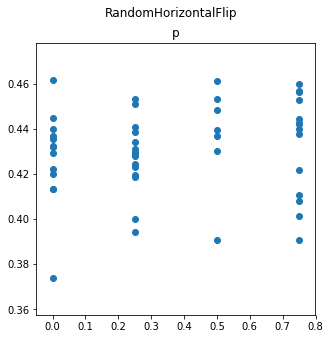

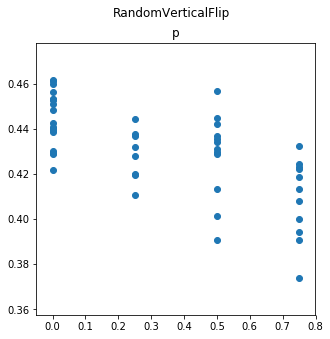

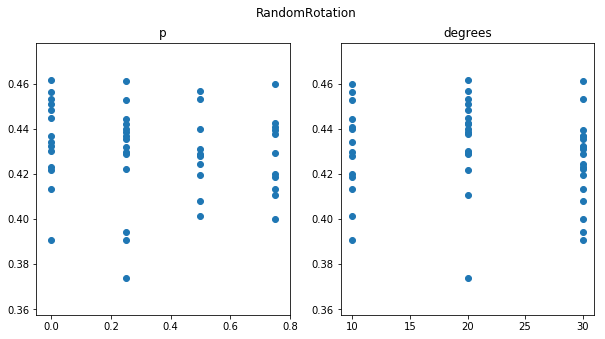

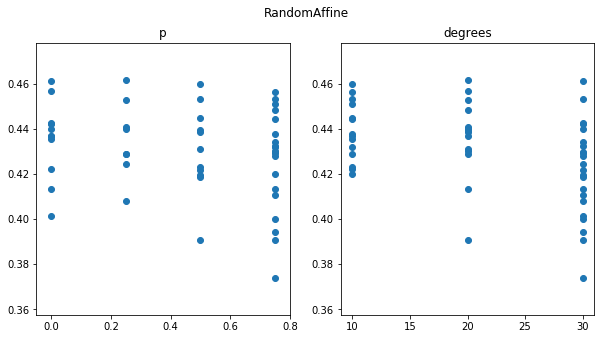

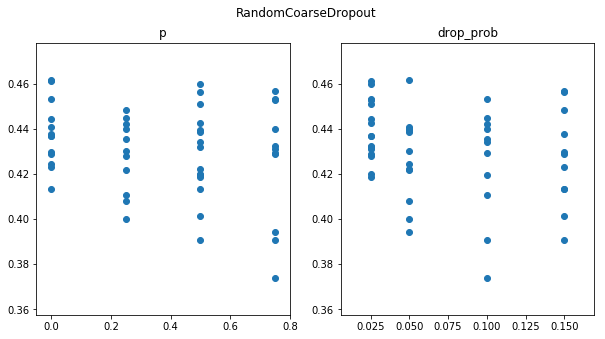

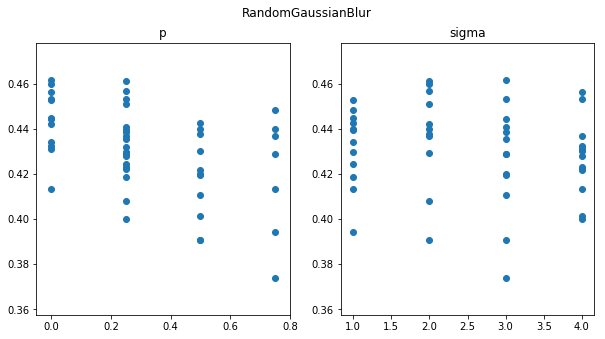

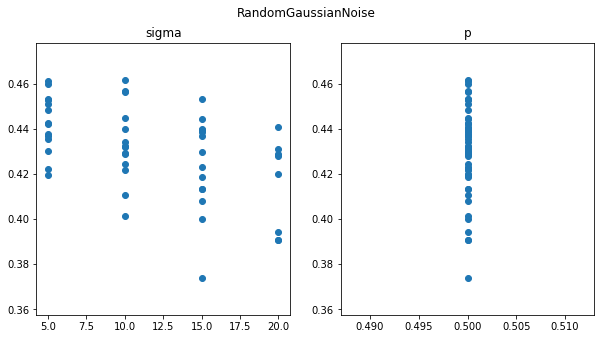

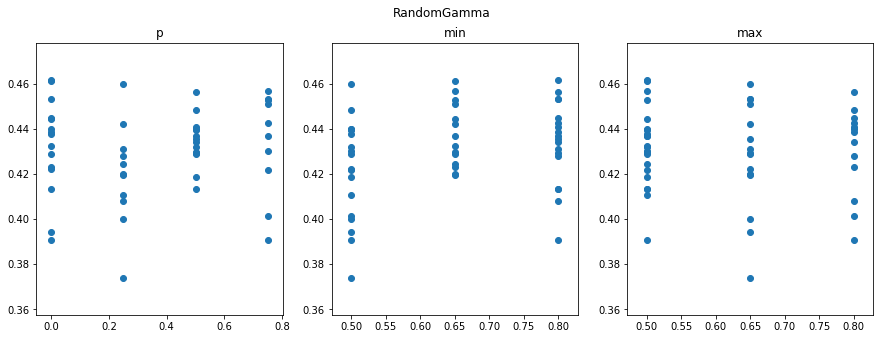

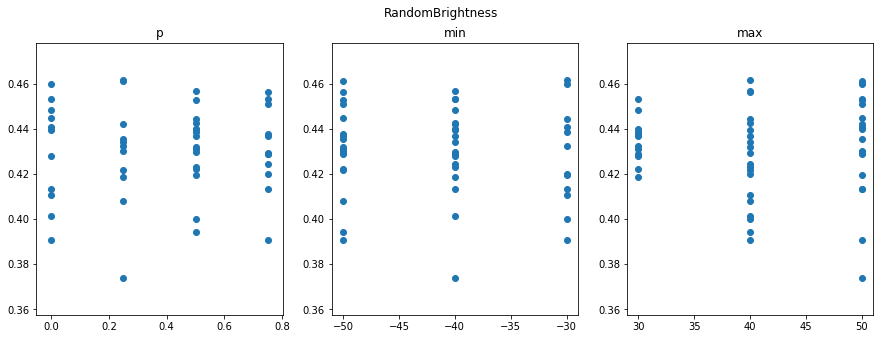

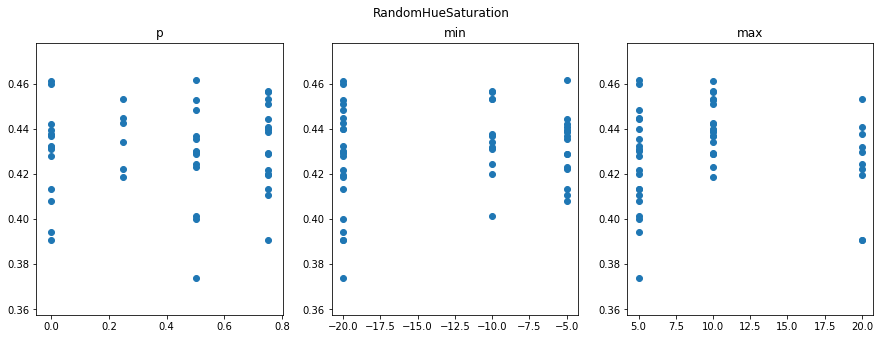

In [163]:
for tname, tvals in parameter_scores.items():
    tvals_fix = {key:val for key,val in tvals.items() if key != 'augmenter'}
    fig, axes = plt.subplots(ncols=len(tvals_fix), figsize=(5*len(tvals_fix), 5))
    if len(tvals) == 1:
        axes = np.array([axes])
    fig.suptitle(tname)
    
    for ax, (pname, pvals) in zip(axes.flatten(), tvals_fix.items()):
        ax.scatter(pvals, score_list)
        ax.set_title(pname)

In [177]:
pickle.dump(augmentations_list, open('augmentations.bin', 'wb'))
pickle.dump(score_list, open('score_list.bin', 'wb'))

In [180]:
top_augs = [transforms.Compose([transforms.Resize((196, 196))] + augmentations_list[idx].transforms[1:])
            for idx in np.argsort(score_list)[::-1][:10]]
top_scores = list()

In [181]:
for aug in top_augs:
    score = score_function(aug)
    print(score)
    top_scores.append(score)

0.502342650749213


0.5014262493857388


0.5015030832850735


0.46571887047792193


0.4998882914982576


0.49155324071355594


0.4979313054733728


0.49831678242121463


0.49788135593220334


0.487181435807799


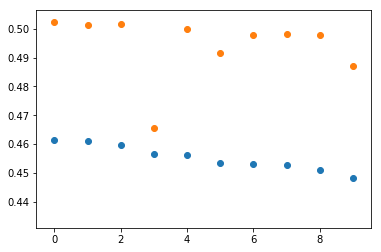

In [184]:
plt.scatter(np.arange(10), np.sort(score_list)[::-1][:10])
plt.scatter(np.arange(10), top_scores)

In [186]:
parameter_scores = defaultdict(lambda: defaultdict(list))

for aug, score in zip(top_augs, top_scores):
    trans_list = aug.transforms[1:-2]
    for t in trans_list:
        for pname, pval in t.__dict__.items():
            parameter_scores[t.__class__.__name__][pname].append(pval)

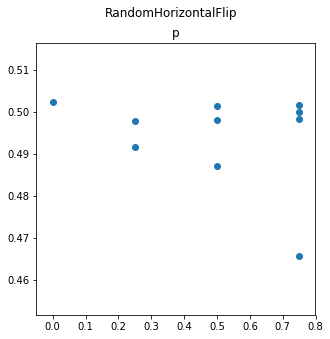

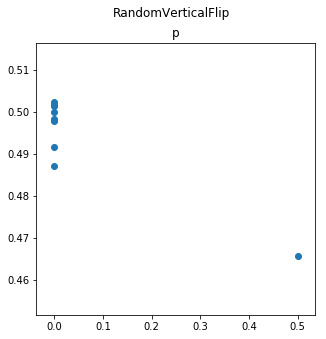

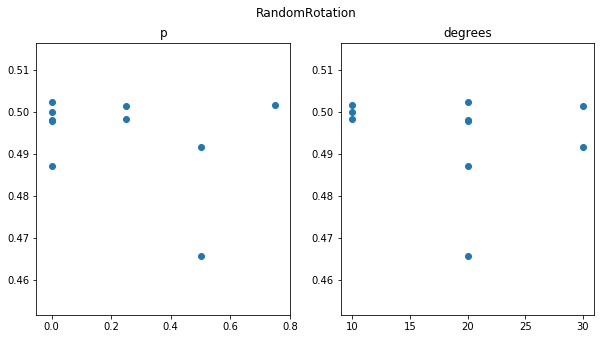

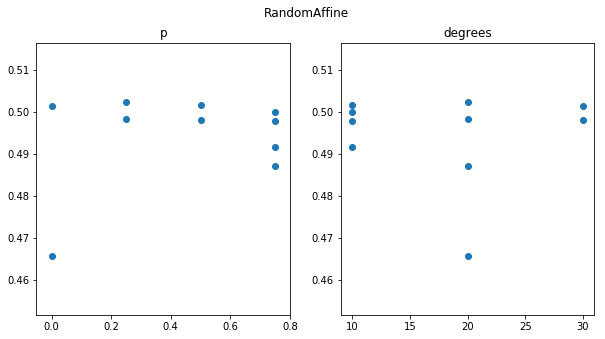

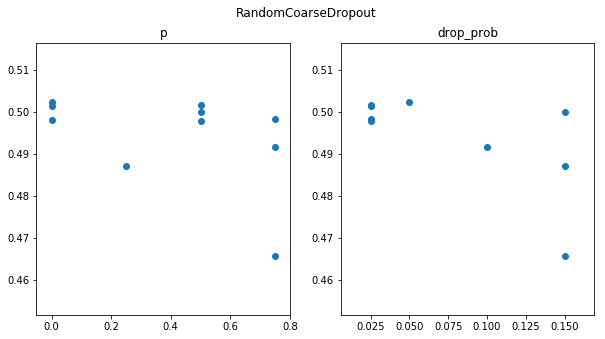

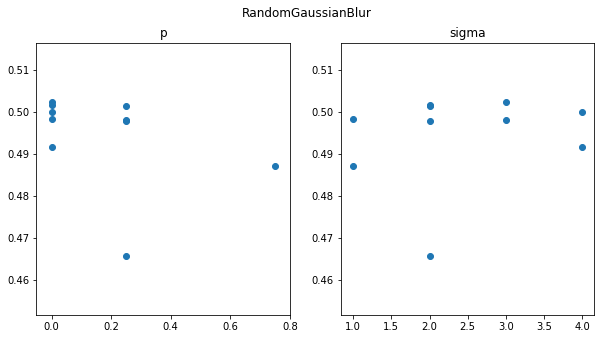

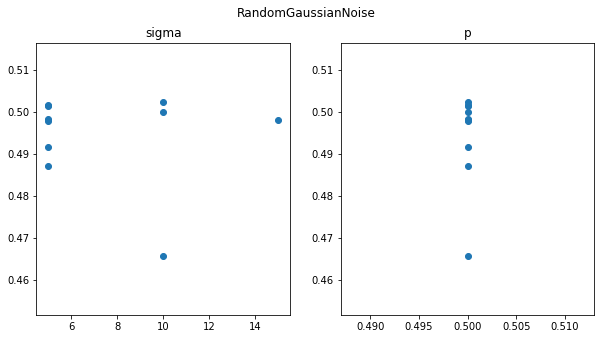

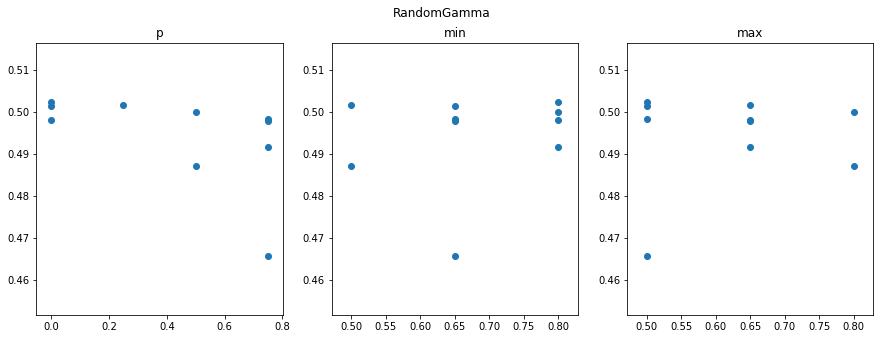

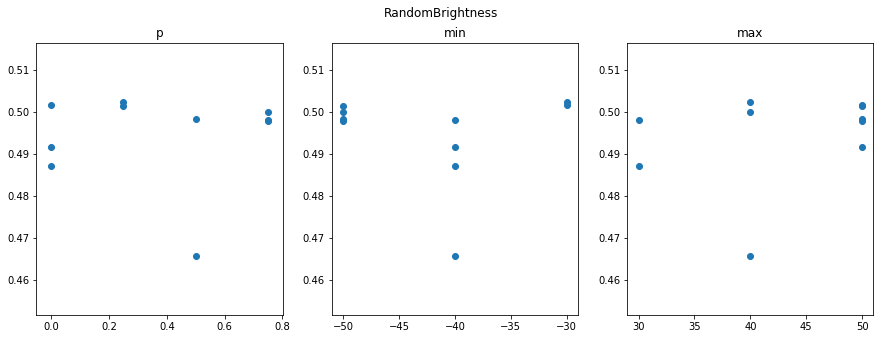

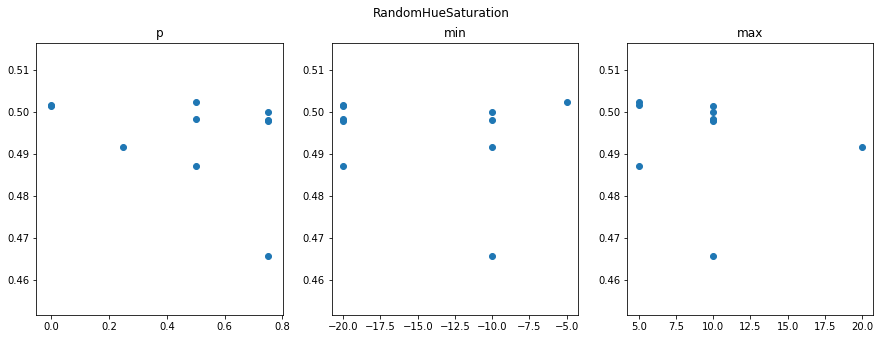

In [187]:
for tname, tvals in parameter_scores.items():
    tvals_fix = {key:val for key,val in tvals.items() if key != 'augmenter'}
    fig, axes = plt.subplots(ncols=len(tvals_fix), figsize=(5*len(tvals_fix), 5))
    if len(tvals) == 1:
        axes = np.array([axes])
    fig.suptitle(tname)
    
    for ax, (pname, pvals) in zip(axes.flatten(), tvals_fix.items()):
        ax.scatter(pvals, top_scores)
        ax.set_title(pname)

In [149]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
train_logits = predict(model,  train_loader)

In [151]:
test_logits = predict(model, test_loader)
test_lbls_oh = create_oh_labels(test_df, len(labels_df))

score = fbeta_score(test_lbls_oh, test_logits >= 0.15, 2, average='micro')

In [152]:
train_lbls_oh = create_oh_labels(train_df, len(labels_df))

In [153]:
score = fbeta_score(test_lbls_oh, test_logits >= 0.1, 2, average='micro')
print(score)

0.014178431052044655


In [ ]:
#score = fbeta_score(test_lbls_oh, test_logits >= 0.25, 2, average='micro')
#print(score)
#0.5104
#0.5086708435891698
# 0.5092509405356842 + only classes with > 3 objects

In [ ]:
def find_threshold(y_true, logits, tvals=np.linspace(0.2, 0.8, 50)):
    yvals = [fbeta_score(y_true, logits >= t, 2) for t in tvals]
    idx = np.argmax(yvals)
    
    return tvals[idx]

def find_threshold_labelwise(all_lbls_oh, min_count, train_lbls_oh, train_logits, base_t=0.2):
    def _find_single(lidx):
        return find_threshold(train_lbls_oh[:,lidx], train_logits[:,lidx], np.linspace(0.1, 0.8, 50))
    
    oh_sum = all_lbls_oh.sum(axis=0)
    frequent_labels = np.where(oh_sum >= min_count)[0]
    
    labelwise_t = np.full(len(labels_df), base_t)
    
    tvals = Parallel(n_jobs=16)(delayed(_find_single)(lidx) for lidx in tqdm_notebook(frequent_labels, leave=False))
    labelwise_t[frequent_labels] = tvals
#     for l in tqdm_notebook(frequent_labels, leave=False):
#         labelwise_t[l] = find_threshold(train_lbls_oh[:,l], train_logits[:,l], np.linspace(0.1, 0.8, 50))
        
    return labelwise_t

In [ ]:
labelwise_t = find_threshold_labelwise(df_labels_oh, 50, train_lbls_oh, train_logits)

In [ ]:
# np.max(f2_history)
# 0.498662390965257 + only classes with > 3 objects

In [ ]:
fbeta_score(test_lbls_oh, (test_logits >= labelwise_t), 2, average='micro')
#0.5135224194232342
#0.5139144833480224
# 0.5168693287873719 + only classes with > 3 objects

In [226]:
class BaselineDataset(Dataset):
    def __init__(self, df, img_size, img_path, nclasses, trans=None, is_test=False):
        self.is_test = is_test
        
        self.img_size = img_size
        self.img_path = img_path
        self.trans = trans
        self.img_names = df.image.values
        self.nclasses = nclasses
        
        if not(self.is_test):
            self.ids = df.attribute_ids.values

    def _read_single(self, img_name):
        img_path = os.path.join(self.img_path, img_name)
        return Image.open(img_path).resize(self.img_size)

    def _oh_labels(self, lbls):
        res = np.zeros(self.nclasses)
        res[lbls] = 1
        
        return res
    
    def __getitem__(self, index):
        img = self._read_single(self.img_names[index])
        
        if self.trans:
            img = self.trans(img)
        
        if self.is_test:
            labels = None
        else:        
            labels = self._oh_labels(self.ids[index])
        
        return img, labels

    def __len__(self):
        return len(self.img_names)

In [227]:
class TTADataset(Dataset):
    def __init__(self, df, img_size, img_path, nclasses, tta_trans, trans):
        self.img_size = img_size
        self.img_path = img_path
        self.trans = trans
        self.tta_trans = tta_trans
        self.img_names = df.image.values
        self.n_trans = len(tta_trans)
        
    def _read_single(self, img_name):
        img_path = os.path.join(self.img_path, img_name)
        return Image.open(img_path).resize(self.img_size)
    
    def __getitem__(self, index):
        base_index = index // self.n_trans
        trans_idx = index % self.n_trans
        
        img = self._read_single(self.img_names[base_index])
#         img_trans = self.trans(self.tta_trans[trans_idx](img))
        img_trans = self.trans(img)
        
        return img_trans, np.zeros(2)

    def __len__(self):
        return len(self.img_names)*self.n_trans
    
def predict_with_tta(model, test_ds, tta_trans, agg_func=np.mean):
    batch_size = 64
    kwargs = {'num_workers': 8, 'pin_memory': True}
    
    tta_ds = TTADataset(test_ds, tta_trans)
    tta_loader = torch.utils.data.DataLoader(tta_ds, batch_size=batch_size, shuffle=False, **kwargs)
    tta_logits = predict(model, tta_loader)
    
    tta_logits = tta_logits.reshape((tta_logits.shape[0]//len(tta_trans), len(tta_trans), tta_logits.shape[1]))
    
    return agg_func(tta_logits, axis=1)

In [228]:
tta_trans = [
            lambda img: img.rotate(90),
            lambda img: img.rotate(-90),
            lambda img: img.transpose(Image.FLIP_TOP_BOTTOM),
            lambda img: img.transpose(Image.FLIP_LEFT_RIGHT)
            ]

In [235]:
batch_size = 64
kwargs = {'num_workers': 8, 'pin_memory': True}

tta_dataset = TTADataset(test_df, (196,196), '../input/train', len(labels_df), tta_trans=tta_trans, trans=val_trans)
tta_loader = torch.utils.data.DataLoader(tta_dataset, batch_size=batch_size, shuffle=False, **kwargs)
tta_logits = predict(model, tta_loader)

tta_logits = tta_logits.reshape((tta_logits.shape[0]//len(tta_trans), len(tta_trans), tta_logits.shape[1]))
# tta_logits = np.max(tta_logits, axis=1)
# return agg_func(tta_logits, axis=1)

In [237]:
score = fbeta_score(test_lbls_oh, tta_logits >= labelwise_t, 2, average='micro')
print(score)

0.5139144833480224
